In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
import os
import sys
print("at directory:", os.getcwd())
print("changing to root directory")
os.chdir("../../..")
print("at directory:", os.getcwd())

at directory: /Users/wilka/git/research/jaxneurorl/projects/humansf/analysis
changing to root directory
at directory: /Users/wilka/git/research/jaxneurorl


In [15]:
# !pip install google-cloud-storage
# !pip install git+https://github.com/wcarvalho/nicewebrl --no-deps
# !pip install ipywidgets
# !pip install polars
# !pip install nicegui

In [16]:
import jax
import jax.numpy as jnp
import functools
from functools import partial
import pandas as pd
import numpy as np
from pprint import pprint
import glob
from glob import glob
import matplotlib.pyplot as plt
import polars as pl
from tqdm.notebook import tqdm

from projects.humansf import data_loading
from projects.humansf import housemaze_analysis
from projects.humansf import data_loading
from projects.humansf import housemaze_trainer
from projects.humansf import housemaze_experiments
from projects.humansf import networks
from housemaze.human_dyna import mazes

from housemaze import renderer
from housemaze import utils
from housemaze.human_dyna import multitask_env as maze
from jaxneurorl import launcher
from jaxneurorl.agents import value_based_basics as vbb


from projects.humansf import download_data

wandb: WARNING `wandb.require('core')` is redundant as it is now the default behavior.


No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy


/Users/wilka/miniforge3/envs/jaxneurorl/lib/python3.10/site-packages/distrax/_src/utils/conversion.py:145: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(jnp.float_)


In [17]:
# data_dir = '/n/holylfs06/LABS/kempner_fellow_wcarvalho/results/jaxrl_result/housemaze_trainer'
data_dir = '/Users/wilka/git/research/results/human_dyna'

In [18]:
# experiments = [
#    'exp1_block1',
#    'exp1_block2',
#    'exp1_block3',
#    'exp1_block4',
# ]
dummy_env_params = housemaze_analysis.get_params()
dummy_rng = jax.random.PRNGKey(42)
task_runner = maze.TaskRunner(task_objects=housemaze_analysis.task_objects)
env = maze.HouseMaze(
    task_runner=task_runner,
    num_categories=200,
)
env = utils.AutoResetWrapper(env)
nenvs=25
example_timestep = env.reset(dummy_rng, dummy_env_params)

# Setup databases

For every algorithm, for every experiment, we will
1. load the algorithm
2. collect K=100 episodes for that algorithm on task objects, we can choose multiple or 1 task object. 
    we'll always use the 1st task object from the train and test sets
3. for each of these K episodes, we're going to create an entry inside a polars dataframe including (1) whether eval or not, (2) algorithm (3) experiment (4) room (5) task_idx

We'll want to options
1. if we reload this script, if possible load (a) algorithm df and (b) algorithm episodes from trajectory and don't recompute
3. option to force recomputation and overwrite data on disk


In the end, we'll have dfs for every algorithm and an episode dict which goes (alg:list). we'll use these to two subselect data for different algorithms. we'll write a small select function which takes in this merged df and this episode dict




We'll want to re-do this for users\

In [8]:
# !ls ~/git/research/results/human_dyna/model_data/*/save_data/*/*/*/analysis

In [9]:
# !rm -r ~/git/research/results/human_dyna/model_data/*/save_data/*/*/*/analysis

In [10]:
model_df_list = []
model_episodes_list = []


### Q-learning

In [11]:
exp = 'exp1'
# qlearning_dir = f'ql/save_data/ql-21/exp={exp}'
qlearning_dir = download_data.qlearning_dir
paths = f'{data_dir}/model_data/{qlearning_dir}/*'
paths = glob(paths)

for path in tqdm(paths):
    seed = path.split('/')[-1].split("=")[-1]
    algorithm = data_loading.load_algorithm(
        path=path,
        name='qlearning',
        make_fns=housemaze_trainer.get_qlearning_fns,
        env=env,
        example_env_params=dummy_env_params,
        nenvs=nenvs,
    )
    df, episodes = housemaze_analysis.get_algorithm_data(
        algorithm=algorithm,
        exp=exp,
        overwrite=False,
        extra_info=dict(seed=seed)
      )
    model_df_list.append(df)
    model_episodes_list.extend(episodes)
    


  0%|          | 0/10 [00:00<?, ?it/s]

No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research

eval,algo,exp,room,task,maze_name,seed
bool,str,str,i64,i64,str,i64
false,"""qlearning""","""exp1""",0,26,"""maze6""",3
true,"""qlearning""","""exp1""",0,40,"""maze6""",3
false,"""qlearning""","""exp1""",0,26,"""maze6_flipped_offtask""",3
true,"""qlearning""","""exp1""",0,40,"""maze6_flipped_offtask""",3
false,"""qlearning""","""exp1""",0,26,"""maze3_open2""",3


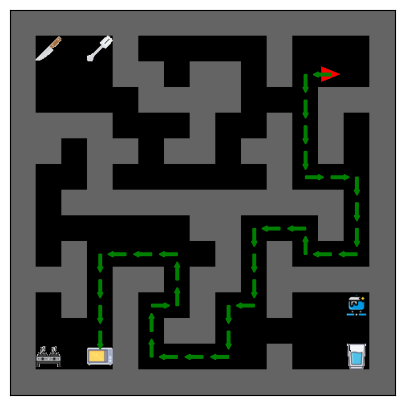

In [12]:
def first(eps): return jax.tree_map(lambda x:x[0], eps)
housemaze_analysis.render_path(first(episodes[0]))
df.head()

### Dyna-Q

In [13]:
exp = 'exp1'
# dyna_dir = f'ql/save_data/ql-21/exp={exp}'
dyna_dir = download_data.dyna_dir
paths = f'{data_dir}/model_data/{dyna_dir}/*'
paths = glob(paths)

for path in tqdm(paths):
    seed = path.split('/')[-1].split("=")[-1]
    algorithm = data_loading.load_algorithm(
        path=path,
        name='dynaq_shared',
        make_fns=functools.partial(housemaze_trainer.get_dynaq_fns,
            env=env,
            env_params=dummy_env_params,
            task_objects=housemaze_analysis.task_objects),
        env=env,
        example_env_params=dummy_env_params,
        nenvs=nenvs)
    df, episodes = housemaze_analysis.get_algorithm_data(
        algorithm=algorithm,
        exp=exp,
        overwrite=False,
        extra_info=dict(seed=seed)
      )
    model_df_list.append(df)
    model_episodes_list.extend(episodes)



  0%|          | 0/10 [00:00<?, ?it/s]

No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research

eval,algo,exp,room,task,budget,maze_name
bool,str,str,i64,i64,str,str
false,"""dfs""","""exp1""",0,26,null,"""maze6"""
true,"""dfs""","""exp1""",0,40,null,"""maze6"""
false,"""dfs""","""exp1""",0,26,null,"""maze6_flipped_offtask"""
true,"""dfs""","""exp1""",0,40,null,"""maze6_flipped_offtask"""
false,"""dfs""","""exp1""",0,26,null,"""maze3_open2"""


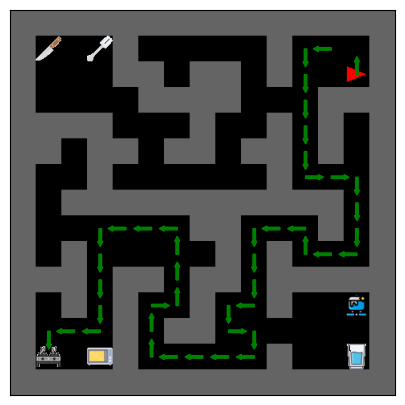

In [16]:
housemaze_analysis.render_path(first(episodes[0]))
df.head()

### BFS/DFS

In [15]:
for algorithm in ['bfs', 'dfs']:
    df, episodes = housemaze_analysis.get_search_data(
        algorithm=algorithm,
        env=env,
        exp='exp1',
        base_path=f'{data_dir}/search_algos',
        budget=None,
        overwrite=False,
        searches=10,
      )
    model_df_list.append(df)
    model_episodes_list.extend(episodes)

No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy


eval,algo,exp,room,task,budget,maze_name
bool,str,str,i64,i64,str,str
false,"""dfs""","""exp1""",0,26,null,"""maze6"""
true,"""dfs""","""exp1""",0,40,null,"""maze6"""
false,"""dfs""","""exp1""",0,26,null,"""maze6_flipped_offtask"""
true,"""dfs""","""exp1""",0,40,null,"""maze6_flipped_offtask"""
false,"""dfs""","""exp1""",0,26,null,"""maze3_open2"""


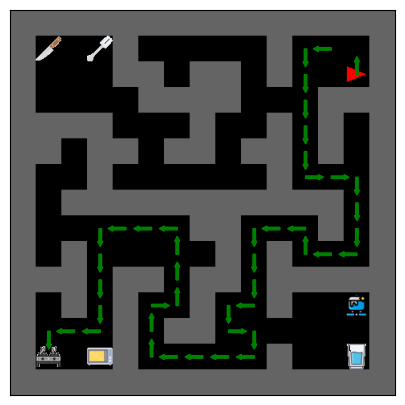

In [17]:
housemaze_analysis.render_path(first(episodes[0]))
df.head()

# put all model things together now

In [18]:
model_df = (
    pl.concat(model_df_list, how="diagonal_relaxed")
    .with_row_count(name="row_number")
    .with_columns(
        pl.col("row_number").add(1).alias("index")
    )
    .drop("row_number")
)
model_df.head()

/var/folders/xy/l2ynyz5d10x4c52rnkln7tp80000gr/T/ipykernel_70617/2695391769.py:2: DeprecationWarning: `DataFrame.with_row_count` is deprecated. Use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  pl.concat(model_df_list, how="diagonal_relaxed")


eval,algo,exp,room,task,maze_name,seed,budget,index
bool,str,str,i64,i64,str,i64,str,u32
false,"""qlearning""","""exp1""",0,26,"""maze6""",6,null,1
true,"""qlearning""","""exp1""",0,40,"""maze6""",6,null,2
false,"""qlearning""","""exp1""",0,26,"""maze6_flipped_offtask""",6,null,3
true,"""qlearning""","""exp1""",0,40,"""maze6_flipped_offtask""",6,null,4
false,"""qlearning""","""exp1""",0,26,"""maze3_open2""",6,null,5


# Okay, now getting human data

In [19]:
!ls -lhtr ~/git/research/results/human_dyna/user_data/*

-rw-r--r--@ 1 wilka  staff   7.3M Sep  8 19:06 /Users/wilka/git/research/results/human_dyna/user_data/data_user=4026679196_name=r0-v2_exp=1_debug=0.json
-rw-r--r--@ 1 wilka  staff   7.5M Sep  8 19:36 /Users/wilka/git/research/results/human_dyna/user_data/data_user=2726279625_name=r0-v2_exp=1_debug=0.json
-rw-r--r--@ 1 wilka  staff   4.2K Sep 19 11:44 /Users/wilka/git/research/results/human_dyna/user_data/Users_df.csv
-rw-r--r--@ 1 wilka  staff   3.1M Sep 19 11:44 /Users/wilka/git/research/results/human_dyna/user_data/Users_timesteps.pickle


In [20]:
# !rm ~/git/research/results/human_dyna/user_data/*3714894224_name* ~/git/research/results/human_dyna/user_data/*2631242498_name*

In [19]:
data_dir = '/Users/wilka/git/research/results/human_dyna/'
files = f'{data_dir}/user_data/exp2/*obj0*.json'
user_base_path = f'{data_dir}/user_data'
files = glob(files)
files

['/Users/wilka/git/research/results/human_dyna//user_data/exp2/data_user=1803160064_name=r0-exp2-obj0-v0_exp=2_debug=0.json',
 '/Users/wilka/git/research/results/human_dyna//user_data/exp2/data_user=792978519_name=r0-exp2-obj0-v0_exp=2_debug=0.json',
 '/Users/wilka/git/research/results/human_dyna//user_data/exp2/data_user=1554047271_name=r0-exp2-obj0-v0_exp=2_debug=0.json',
 '/Users/wilka/git/research/results/human_dyna//user_data/exp2/data_user=2075250737_name=r0-exp2-obj0-v0_exp=2_debug=0.json']

In [21]:
import json
for file in files:
    with open(file, 'r') as f:
        data = json.load(f)
        finished = data[-1].get("finished", False)
        if finished:
            print(data[-1]['feedback'])

Everything seemed fine although every once in a while, the cursor seemed to jump in the wrong direction.
easy to do
Please, don't hold this against me but I found this HIT to be absolutely EXCRUTIATING. The red cursor/arrow rarely responded correctly to ANY of my keyboard commands and was just going in any direction it felt like. I wished that I could have provided you better data but lack of control of the red arrow/cursor made it impossible to do so. Despite what the data may tell you about this HIT, I gave it my best possible effort despite the circumstances.



In [24]:
data_dir = '/Users/wilka/git/research/results/human_dyna'
files = f'{data_dir}/user_data/*.json'
files = glob(files)
files

['/Users/wilka/git/research/results/human_dyna/user_data/data_user=2726279625_name=r0-v2_exp=1_debug=0.json',
 '/Users/wilka/git/research/results/human_dyna/user_data/data_user=4026679196_name=r0-v2_exp=1_debug=0.json']

In [25]:
user_df, user_data = data_loading.make_all_episode_data(
    files=files,
    example_timestep=example_timestep,
    overwrite=False,
)

Processing files:   0%|          | 0/2 [00:00<?, ?it/s]

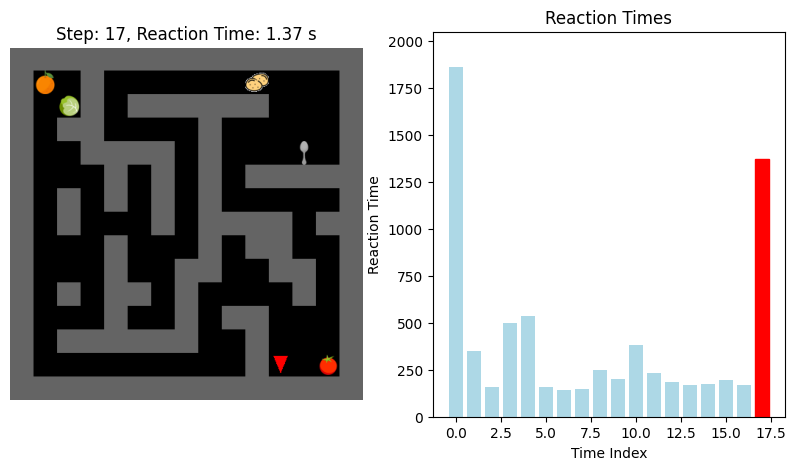

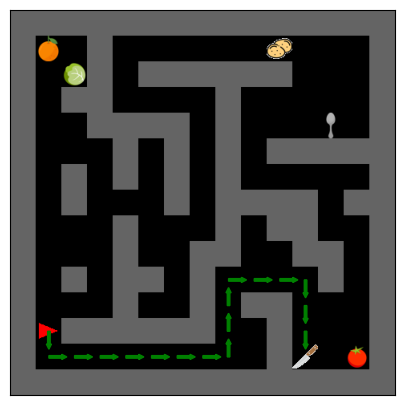

In [30]:
housemaze_analysis.create_episode_reaction_times_video(user_data[0])
housemaze_analysis.render_path(user_data[0])

In [31]:
user_df.head()

index,stage,block,manipulation,episode_idx,eval,user_episode_idx,task,room,user_id,age,sex
u32,str,str,i64,i64,bool,i64,i64,i64,i64,i64,str
1,null,"""reusing longer of two paths wh…",3,1,false,0,43,1,4026679196,39,"""Male"""
2,null,"""reusing longer of two paths wh…",3,2,false,1,43,1,4026679196,39,"""Male"""
3,null,"""reusing longer of two paths wh…",3,3,false,2,43,1,4026679196,39,"""Male"""
4,null,"""reusing longer of two paths wh…",3,4,false,3,43,1,4026679196,39,"""Male"""
5,null,"""reusing longer of two paths wh…",3,5,false,4,3,1,4026679196,39,"""Male"""


# Now compute metrics for each manipulation

In [32]:
def get_user_samples(**kwargs):
    eval_df = user_df.filter(**kwargs)
    idxs = np.array(eval_df['index'])-1
    return idxs

def plot_user_sample(idx=0, ax=None, **kwargs):
    eval_df = user_df.filter(**kwargs)
    idxs = np.array(eval_df['index'])-1
    print(idxs[idx])
    housemaze_analysis.render_path(user_data[idxs[idx]], ax=ax)

def plot_users_sample(user_settings):
    num_users = min(len(user_df['user_id'].unique()), 4)
    fig, axes = plt.subplots(1, num_users, figsize=(3*num_users, 3), squeeze=False)
    axes = axes.flatten()
    
    # Iterate through unique models and plot each one
    users = list(user_df['user_id'].unique())[:num_users]
    for i, user in enumerate(users):
        plot_user_sample(ax=axes[i], user_id=user, **user_settings)
        axes[i].set_title(user)
    
    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

get_human_data = partial(housemaze_analysis.get_human_data,
                         user_df=user_df, user_data=user_data)

In [33]:
def plot_model_sample(idx=0, ax=None, **kwargs):
    eval_df = model_df.filter(**kwargs)
    idxs = np.array(eval_df['index'])-1
    print(idxs[idx])
    housemaze_analysis.render_path(first(model_episodes_list[idxs[idx]]), ax=ax)


def plot_models_sample(model_settings):
    num_models = len(model_df['algo'].unique())
    fig, axes = plt.subplots(1, num_models, figsize=(3*num_models, 3), squeeze=False)
    axes = axes.flatten()
    
    # Iterate through unique models and plot each one
    for i, model in enumerate(model_df['algo'].unique()):
        plot_model_sample(ax=axes[i], algo=model, **model_settings)
        axes[i].set_title(model)
    
    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

get_model_data = partial(housemaze_analysis.get_model_data,
                         model_df=model_df, model_data=model_episodes_list)


In [34]:
model_df['algo'].unique()

algo
str
"""dynaq_shared"""
"""dfs"""
"""qlearning"""
"""bfs"""


In [35]:
model_df['maze_name'].unique()

maze_name
str
"""maze6_flipped_offtask"""
"""maze3_onpath_shortcut_r"""
"""maze5"""
"""maze3"""
"""maze3_offpath_shortcut_r"""
"""maze6"""
"""maze3_open2"""
"""maze3_r"""


---
## Manipulation 1: shortcut is introduced

Here, a short is introduced at evaluation time and we want to see if users follow the short-cut or if they use the old path

How will we compute for the user?
1. for each user, get the eval episode data
2. look for point on map which corresponds to "shortcut"
3. compute binary if the episode crossed through there

48


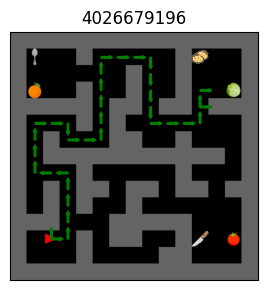

In [36]:
# plot_user_sample(manipulation=1, eval=True)
plot_users_sample(dict(manipulation=1, eval=True))
plt.show()

325
165
5
341


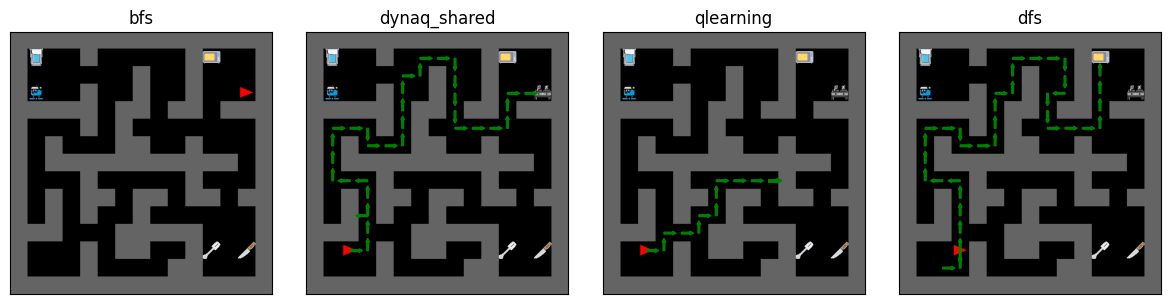

In [30]:
m1_model_settings = dict(maze_name='maze3_open2', eval=True)
plot_models_sample(m1_model_settings)


In [31]:
# get user data
def went_to_position(path, position):
    match = np.array(position) == path
    match = (match).sum(-1) == 2
    return match.any()

def reused_path(e):
    new_path = went_to_position(e.positions, (6,10))
    old_path = went_to_position(e.positions, (0,6))
    assert not (new_path and old_path)
    return float(old_path)

reused_path_data = dict(
    # vector of people
    human=get_human_data(fn=reused_path, manipulation=1, eval=True),
    # vector of seeds
    qlearning=get_model_data(fn=reused_path, algo="qlearning", **m1_model_settings),
    dyna=get_model_data(fn=reused_path, algo="dynaq_shared", **m1_model_settings),
    bfs=get_model_data(fn=reused_path, algo='bfs', **m1_model_settings),
    dfs=get_model_data(fn=reused_path, algo='dfs', **m1_model_settings),
)

reused_path_data

{'human': [1.0, 1.0],
 'qlearning': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'dyna': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'bfs': array([0.], dtype=float32),
 'dfs': array([0.], dtype=float32)}

In [32]:
success_data = dict(
    # vector of people
    human=get_human_data(fn=housemaze_analysis.success, manipulation=1, eval=True),
    # vector of seeds
    qlearning=get_model_data(fn=housemaze_analysis.success, algo="qlearning", **m1_model_settings),
    dyna=get_model_data(fn=housemaze_analysis.success,algo="dynaq_shared",  **m1_model_settings),
    bfs=get_model_data(fn=housemaze_analysis.success, algo='bfs', **m1_model_settings),
    dfs=get_model_data(fn=housemaze_analysis.success, algo='dfs', **m1_model_settings),
)
success_data

{'human': [Array(0., dtype=float32), Array(0., dtype=float32)],
 'qlearning': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'dyna': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32),
 'bfs': array([1.], dtype=float32),
 'dfs': array([0.6], dtype=float32)}

---
## Manipulation 3: reusing longer of two paths which matches training path

Here there are 2 paths. do people take the short or long one?


11


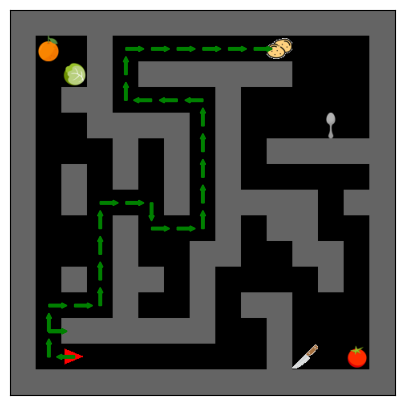

In [44]:
plot_user_sample(manipulation=3, eval=True)

5


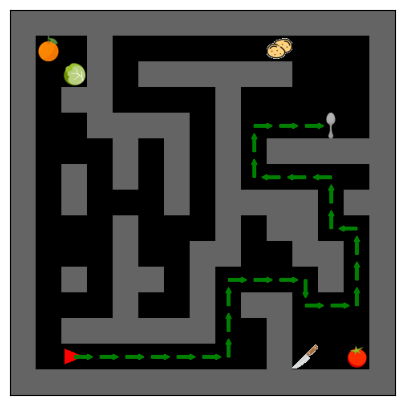

In [45]:
plot_user_sample(idx=5, manipulation=3, eval=False)

22


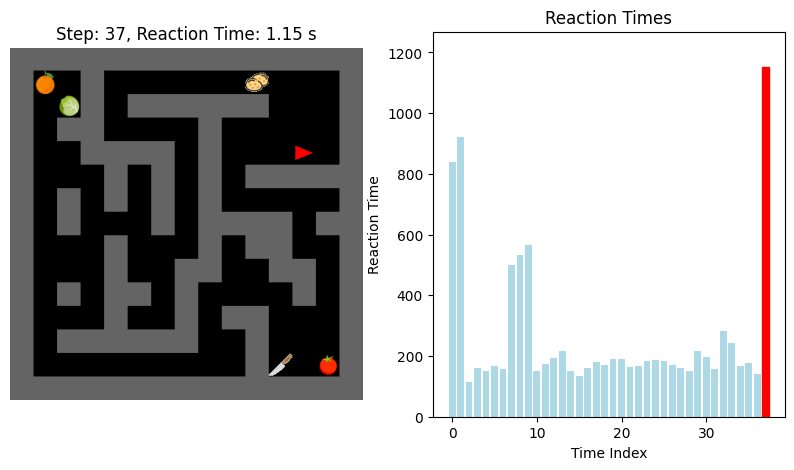

In [49]:
idxs = get_user_samples(manipulation=3, eval=False)[::-1]
print(len(idxs))
# for idx in idxs:
video = housemaze_analysis.create_episode_reaction_times_video(
    user_data[idxs[3]],
    output_file=f'/tmp/housemaze_anlaysis/rt_video_{idx}.mp4',
    html=True)
#     break

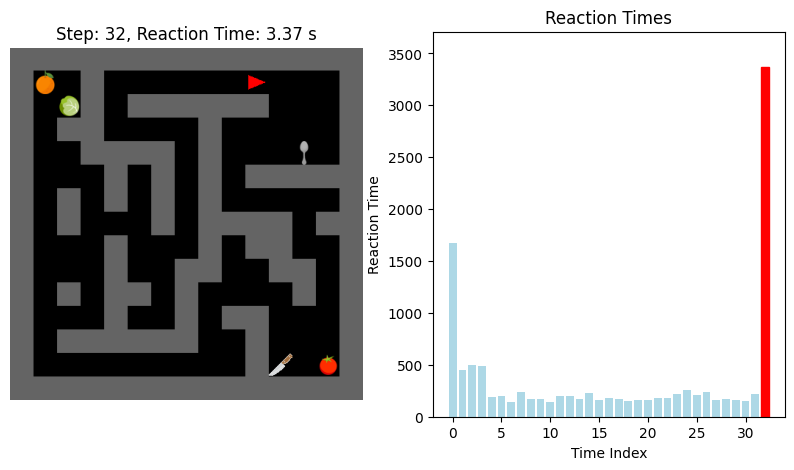

In [46]:
idxs = get_user_samples(manipulation=3, eval=True, , user_id=2726279625)[::-1]
for idx in idxs:
    video = housemaze_analysis.create_episode_reaction_times_video(
        user_data[idx],
        output_file=f'/tmp/housemaze_anlaysis/rt_video_{idx}.mp4',
        html=True)
    break

343
167
327
7


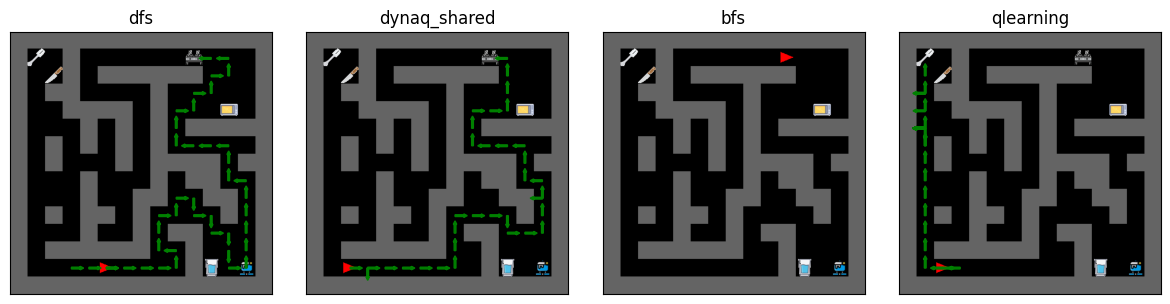

In [34]:
m3_model_settings = dict(maze_name='maze5', eval=True)
plot_models_sample(m3_model_settings)
# housemaze_analysis.render_path(first(model_episodes_list[170]))


In [40]:
def fn(e):
    new_path = went_to_position(e.positions, (0,3))
    return float(new_path)

new_path_data = dict(
    # vector of people
    human=get_human_data(fn=fn, manipulation=3, eval=True),
    # vector of seeds
    qlearning=get_model_data(fn=fn, algo="qlearning", **m3_model_settings),
    dyna=get_model_data(fn=fn, algo="dynaq_shared", **m3_model_settings),
    bfs=get_model_data(fn=fn, algo='bfs', **m3_model_settings),
    dfs=get_model_data(fn=fn, algo='dfs', **m3_model_settings),

)

new_path_data

{'human': [1.0, 1.0],
 'qlearning': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'dyna': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'bfs': array([0.], dtype=float32),
 'dfs': array([0.], dtype=float32)}

In [41]:
success_data = dict(
    # vector of people
    human=get_human_data(fn=housemaze_analysis.success, manipulation=3, eval=True),
    # vector of seeds
    qlearning=get_model_data(fn=housemaze_analysis.success, algo="qlearning", **m3_model_settings),
    dyna=get_model_data(fn=housemaze_analysis.success,algo="dynaq_shared",  **m3_model_settings),
    bfs=get_model_data(fn=housemaze_analysis.success, algo='bfs', **m3_model_settings),
    dfs=get_model_data(fn=housemaze_analysis.success, algo='dfs', **m3_model_settings),
)
success_data

{'human': [Array(1., dtype=float32), Array(1., dtype=float32)],
 'qlearning': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'dyna': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32),
 'bfs': array([1.], dtype=float32),
 'dfs': array([0.6], dtype=float32)}

## Manipulation 2: faster when on-path but further than off-path but closer
In both tests, a shortcut is introduced. In the first, the agent is tested on the same path it trained on. In the second, the agent is tested on a different path.reusing longer of two paths which matches training path

Here there are 2 paths. do people take the short or long one?


what do I want to do?
1. I want to get the user data for each participant for the episode
2. I want to get a vector of the reaction times. for now, just plot that as a histogram. 4 histograms alone may be informative....

Map changed, new location, on path
25
87


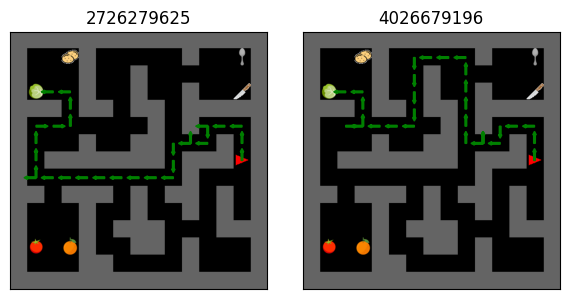

Map changed, new location, off-path
26
88


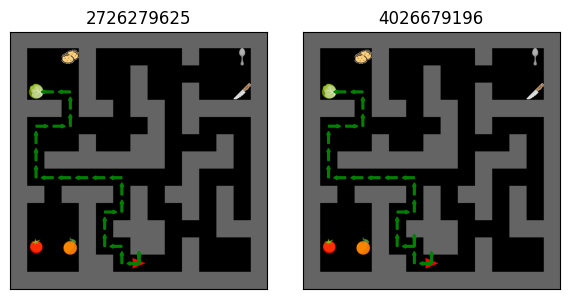

In [55]:
sub_df = user_df.filter(manipulation=2, eval=True)
for stage in sub_df['stage'].unique():
    print(stage)
    plot_users_sample(dict(manipulation=2, eval=True, stage=stage))
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reaction_hists(user_df, user_data, user_settings, y_max):
    num_users = min(len(user_df['user_id'].unique()), 4)
    fig, axes = plt.subplots(1, num_users, figsize=(3*num_users, 3), squeeze=False)
    axes = axes.flatten()
    
    users = list(user_df['user_id'].unique())[:num_users]
    
    for i, user in enumerate(users):
        eval_df = user_df.filter(user_id=user, **user_settings)
        idxs = np.array(eval_df['index'])-1
        assert len(idxs) == 1, f'{len(idxs)} options?'
        episode_data = user_data[idxs[0]]
        reaction_times = episode_data.reaction_times
        
        axes[i].bar(np.arange(len(reaction_times)), reaction_times)
        axes[i].set_title(user)
        axes[i].set_ylim(0, y_max)  # Set the same y-axis limit for all plots
    
    plt.suptitle(f"Stage: {user_settings['stage']}")
    plt.tight_layout()
    plt.show()

def plot_all_stages(user_df, user_data, manipulation=2, eval=True):
    sub_df = user_df.filter(manipulation=manipulation, eval=eval)
    stages = sub_df['stage'].unique()
    
    # First, find the global maximum reaction time across all stages
    all_reaction_times = []
    for stage in stages:
        stage_df = sub_df.filter(stage=stage)
        for user in stage_df['user_id'].unique():
            eval_df = stage_df.filter(user_id=user)
            idxs = np.array(eval_df['index'])-1
            episode_data = user_data[idxs[0]]
            import ipdb; ipdb.set_trace()
            all_reaction_times.extend(episode_data.reaction_times[:-1])
    
    global_y_max = max(all_reaction_times)
    
    # Now plot for each stage
    for stage in stages:
        print(f"Stage: {stage}")
        plot_reaction_hists(user_df, user_data, 
                            dict(manipulation=manipulation, eval=eval, stage=stage),
                            global_y_max)

# Usage
plot_all_stages(user_df, user_data)

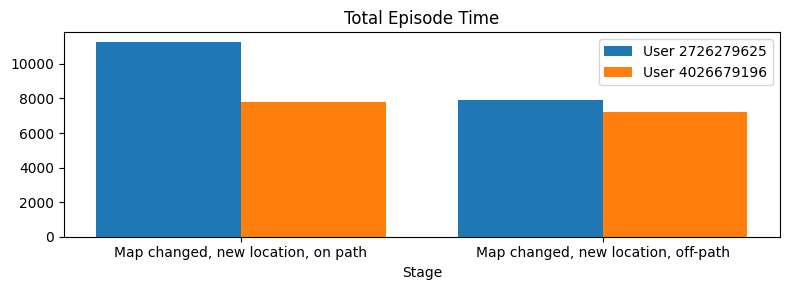

In [63]:
def plot_reaction_times_by_stage(user_df, user_data, user_settings):
    # Filter the dataframe based on user settings
    sub_df = user_df.filter(**user_settings)
    
    # Get unique stages and users
    stages = sub_df['stage'].unique()
    users = sub_df['user_id'].unique()
    
    # Prepare data for plotting
    data = []
    for user in users:
        user_totals = []
        for stage in stages:
            eval_df = sub_df.filter(user_id=user, stage=stage)
            if len(eval_df) > 0:
                idx = np.array(eval_df['index'])[0] - 1
                episode_data = user_data[idx]
                reaction_times_sum = sum(episode_data.reaction_times)
                user_totals.append(reaction_times_sum)
            else:
                user_totals.append(0)
        data.append(user_totals)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 3))
    
    bar_width = 0.8 / len(users)
    index = np.arange(len(stages))
    
    for i, (user, user_data) in enumerate(zip(users, data)):
        ax.bar(index + i * bar_width, user_data, bar_width, label=f'User {user}')
    
    ax.set_xlabel('Stage')
    # ax.set_ylabel('Total Episode Time')
    ax.set_title('Total Episode Time')
    ax.set_xticks(index + bar_width * (len(users) - 1) / 2)
    ax.set_xticklabels(stages)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Usage
user_settings = dict(manipulation=2, eval=True)
plot_reaction_times_by_stage(user_df, user_data, user_settings)


## Manipulation 4: probing for planning near goal
At test time, we'll change the location of the off-task object so it's equidistant from path during training.

We'll first query when the off-task object is in the same location as during training. We'll then query again with it being in a different locaiton.

off-task object flipped
12
74


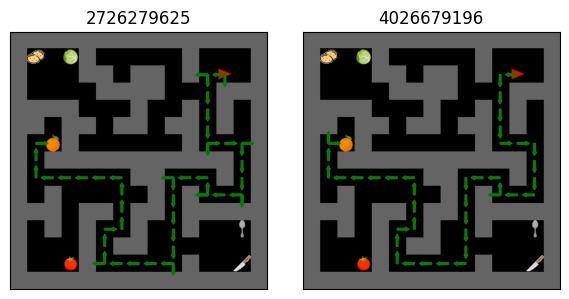

off-task object regular
11
73


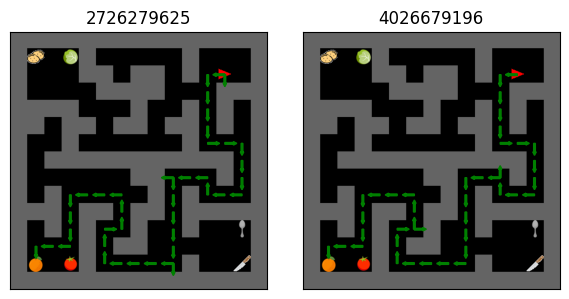

In [58]:
sub_df = user_df.filter(manipulation=4, eval=True)
for stage in sub_df['stage'].unique():
    print(stage)
    plot_users_sample(dict(manipulation=4, eval=True, stage=stage))
    plt.show()

Stage: off-task object regular


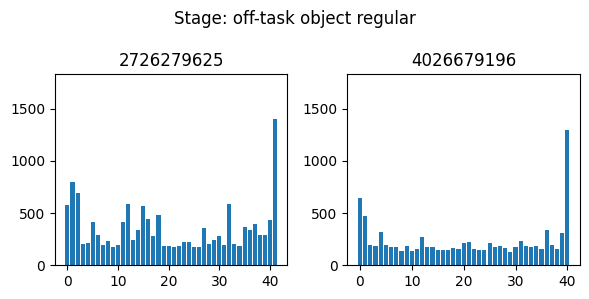

Stage: off-task object flipped


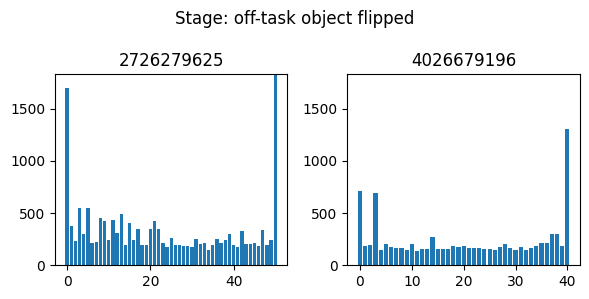

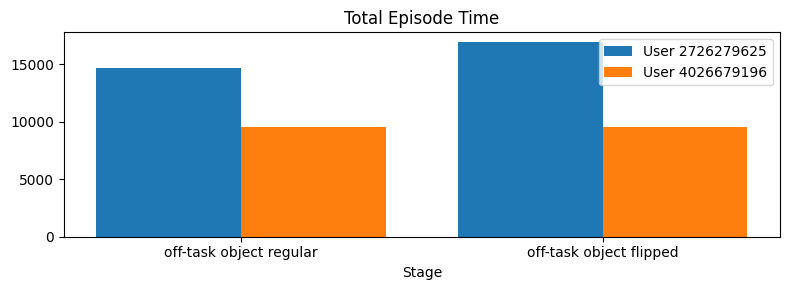

In [65]:
user_settings = dict(manipulation=4, eval=True)
plot_all_stages(user_df, user_data, **user_settings)
plot_reaction_times_by_stage(user_df, user_data, user_settings)

# sub_df = user_df.filter(**user_settings)
# for stage in sub_df['stage'].unique():
#     print(stage)
#     plot_reaction_hists(dict(**user_settings, stage=stage))
#     plt.show()


In [ ]:
plot_reaction_times_by_stage(user_df, user_data, user_settings)

# Plots

In [45]:
sorted(list(df['key'].unique()))

['bfs_maze3_150_train=False',
 'bfs_maze3_offpath_shortcut_150_train=False',
 'bfs_maze3_onpath_150_train=False',
 'bfs_maze3_onpath_shortcut_150_train=False',
 'bfs_maze3_open2_150_train=False',
 'bfs_maze3_open_150_train=False',
 'dfs_maze3_150_train=False',
 'dfs_maze3_offpath_shortcut_150_train=False',
 'dfs_maze3_onpath_150_train=False',
 'dfs_maze3_onpath_shortcut_150_train=False',
 'dfs_maze3_open2_150_train=False',
 'dfs_maze3_open_150_train=False',
 'dynaq_shared_maze3_offpath_shortcut_train=False',
 'dynaq_shared_maze3_offpath_shortcut_train=True',
 'dynaq_shared_maze3_onpath_shortcut_train=False',
 'dynaq_shared_maze3_onpath_shortcut_train=True',
 'dynaq_shared_maze3_onpath_train=False',
 'dynaq_shared_maze3_onpath_train=True',
 'dynaq_shared_maze3_open2_train=False',
 'dynaq_shared_maze3_open2_train=True',
 'dynaq_shared_maze3_open_train=False',
 'dynaq_shared_maze3_open_train=True',
 'dynaq_shared_maze3_train=False',
 'dynaq_shared_maze3_train=True',
 'qlearning_maze3_offp

# Plots

### Signature 1: Offtask-Dyna will succeed on getting to a task that wasn't a train task
### Signature 2: DFS will take the optimal path, Offtask-Dyna will take the long path

/tmp/ipykernel_2270999/3537544777.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, ha='right', fontsize=xlabel_fontsize)
/tmp/ipykernel_2270999/3537544777.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, ha='right', fontsize=xlabel_fontsize)
/tmp/ipykernel_2270999/3537544777.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, ha='right', fontsize=xlabel_fontsize)
/tmp/ipykernel_2270999/3537544777.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, ha='right', fontsize=xlabel_fontsize)
/tmp/ipykernel_2270999/3537544777.py:47: UserWarning: set_ti

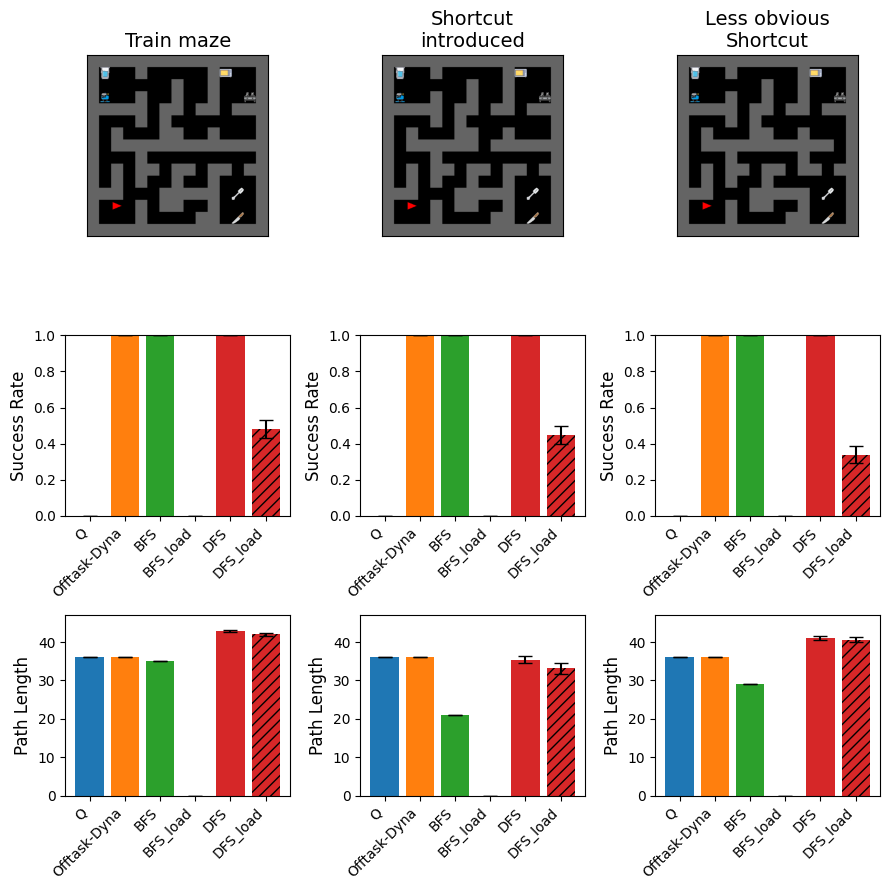

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import jax
from collections import OrderedDict


def render_env(env_params, ax):
    map_init = jax.tree_map(lambda x:x[0], env_params.reset_params.map_init)
    grid = np.asarray(map_init.grid)    
    img = renderer.create_image_from_grid(
        map_init.grid,
        map_init.agent_pos,
        map_init.agent_dir,
        image_dict)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])

def get(key, val):
    data = df[(df['key'] == key)][val]
    # Filter out inf and nan values
    finite_data = data[np.isfinite(data)]
    if len(finite_data) > 0:
        mean = finite_data.mean()
        std = finite_data.std()/np.sqrt(len(finite_data))
    else:
        mean = 0
        std = 0
    return mean, std

def create_bar_plot(ax, data_dict, ylabel='Success Rates', title='', color_dict=None, hatches_dict=None, title_fontsize=12, ylabel_fontsize=10, xlabel_fontsize=10):
    names = list(data_dict.keys())
    values = [v[0] for v in data_dict.values()]  # Means
    errors = [v[1] for v in data_dict.values()]  # Standard deviations
    
    colors = [color_dict[name.split('_')[0]] for name in names] if color_dict else None
    hatches = [hatches_dict.get(name, '') for name in names] if hatches_dict else None
    
    bars = ax.bar(names, values, yerr=errors, capsize=5, color=colors)
    
    # Apply hatches after creating bars
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
    
    ax.set_ylabel(ylabel, fontsize=ylabel_fontsize)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticklabels(names, ha='right', fontsize=xlabel_fontsize)
    ax.tick_params(axis='y')

def create_complete_figure(maze_list, show_metrics='both', base_height=3, base_width=3, title_fontsize=12, ylabel_fontsize=10, xlabel_fontsize=10):
    n_mazes = len(maze_list)
    
    if show_metrics == 'both':
        n_rows = 3
    else:
        n_rows = 2
    
    fig, axs = plt.subplots(n_rows, n_mazes, figsize=(base_width*n_mazes, base_height*n_rows))
    
    color_dict = {
        'Q': '#1f77b4',  # blue
        'Offtask-Dyna': '#ff7f0e',  # orange
        'BFS': '#2ca02c',  # green
        'BFS_load': '#2ca02c',  # green
        'DFS': '#d62728',  # red
        'DFS_load': '#d62728',  # red
    }
    hatches_dict = {
        'BFS_load': '///',
        'DFS_load': '///'
    }
    y_min = {1: float('inf'), 2: float('inf')}
    y_max = {1: float('-inf'), 2: float('-inf')}
    # First pass: calculate global y-limits for each row
    for i, maze in enumerate(maze_list):
        if show_metrics in ['sr', 'both']:
            data_sr = {
                'Q': get(f'qlearning_{maze}_train=False', 'sr'),
                'Offtask-Dyna': get(f'dynaq_shared_{maze}_train=True', 'sr'),
                'BFS': get(f'bfs_{maze}_1000_train=False', 'sr'),
                'BFS_load': get(f'bfs_{maze}_150_train=False', 'sr'),
                'DFS': get(f'dfs_{maze}_1000_train=False', 'sr'),
                'DFS_load': get(f'dfs_{maze}_150_train=False', 'sr'),
            }
            sr_row = 1 if show_metrics == 'both' else 1
            values = [v[0] for v in data_sr.values()]
            errors = [v[1] for v in data_sr.values()]
            y_min[sr_row] = min(y_min[sr_row], min(v - e for v, e in zip(values, errors)))
            y_max[sr_row] = max(y_max[sr_row], max(v + e for v, e in zip(values, errors)))
        
        if show_metrics in ['pl', 'both']:
            data_pl = {
                'Q': get(f'qlearning_{maze}_train=False', 'pl'),
                'Offtask-Dyna': get(f'dynaq_shared_{maze}_train=True', 'pl'),
                'BFS': get(f'bfs_{maze}_1000_train=False', 'pl'),
                'BFS_load': get(f'bfs_{maze}_150_train=False', 'pl'),
                'DFS': get(f'dfs_{maze}_1000_train=False', 'pl'),
                'DFS_load': get(f'dfs_{maze}_150_train=False', 'pl'),
            }
            pl_row = 2 if show_metrics == 'both' else 1
            values = [v[0] for v in data_pl.values()]
            errors = [v[1] for v in data_pl.values()]
            y_min[pl_row] = min(y_min[pl_row], min(v - e for v, e in zip(values, errors)))
            y_max[pl_row] = max(y_max[pl_row], max(v + e for v, e in zip(values, errors)))
    
    for i, maze in enumerate(maze_list):
        # Render maze
        render_env(get_params(getattr(mazes, maze)), axs[0, i])
        axs[0, i].set_title(maze_list[maze], fontsize=title_fontsize)
        
        if show_metrics in ['sr', 'both']:
            # Plot success rate
            data_sr = {
                'Q': get(f'qlearning_{maze}_train=False', 'sr'),
                'Offtask-Dyna': get(f'dynaq_shared_{maze}_train=True', 'sr'),
                'BFS': get(f'bfs_{maze}_1000_train=False', 'sr'),
                'BFS_load': get(f'bfs_{maze}_150_train=False', 'sr'),
                'DFS': get(f'dfs_{maze}_1000_train=False', 'sr'),
                'DFS_load': get(f'dfs_{maze}_150_train=False', 'sr'),
            }
            sr_row = 1 if show_metrics == 'both' else 1
            create_bar_plot(
                axs[sr_row, i],
                data_dict=data_sr,
                # title=f'{maze}',
                color_dict=color_dict,
                hatches_dict=hatches_dict,
                ylabel='Success Rate',
                title_fontsize=title_fontsize,
                ylabel_fontsize=ylabel_fontsize,
                xlabel_fontsize=xlabel_fontsize,
            )
            axs[sr_row, i].set_ylim(y_min[sr_row], int(1.1*y_max[sr_row]))
        
        if show_metrics in ['pl', 'both']:
            # Plot path length
            data_pl = {
                'Q': get(f'qlearning_{maze}_train=False', 'pl'),
                'Offtask-Dyna': get(f'dynaq_shared_{maze}_train=True', 'pl'),
                'BFS': get(f'bfs_{maze}_1000_train=False', 'pl'),
                'BFS_load': get(f'bfs_{maze}_150_train=False', 'pl'),
                'DFS': get(f'dfs_{maze}_1000_train=False', 'pl'),
                'DFS_load': get(f'dfs_{maze}_150_train=False', 'pl'),
            }
            pl_row = 2 if show_metrics == 'both' else 1
            create_bar_plot(
                axs[pl_row, i],
                data_dict=data_pl,
                # title=f'{maze}',
                color_dict=color_dict,
                hatches_dict=hatches_dict,
                ylabel='Path Length',
                ylabel_fontsize=ylabel_fontsize,
                xlabel_fontsize=xlabel_fontsize,
            )
            axs[pl_row, i].set_ylim(y_min[pl_row], int(y_max[pl_row]*1.1))
    
    plt.tight_layout()
    plt.show()


# Example usage
maze_list = OrderedDict(
    maze3='Train maze',
    maze3_open='Shortcut\nintroduced',
    maze3_open2='Less obvious\nShortcut',
)
# Show both success rate and path length
title_fontsize=14
ylabel_fontsize=12
xlabel_fontsize=10
create_complete_figure(
    maze_list, show_metrics='both',
    base_height=3,
    base_width=3,
    title_fontsize=title_fontsize,
    ylabel_fontsize=ylabel_fontsize,
    xlabel_fontsize=xlabel_fontsize,
  )
# Show only success rate
# create_complete_figure(maze_list, show_metrics='sr')
# Show only path length
# create_complete_figure(maze_list, show_metrics='pl', title_fontsize=title_fontsize, label_fontsize=label_fontsize)

# Visualizing models

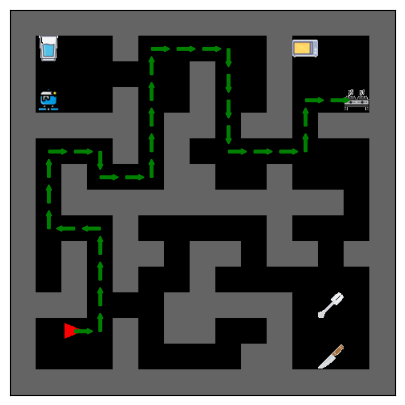

In [57]:
def render_model_path(traj, ep_idx = 0, ax=None):
    # get actions that are in episode
    in_episode = housemaze_analysis.get_in_episode(traj.timestep)[ep_idx]
    actions = traj.action[ep_idx][in_episode][:-1]
    # positions in episode
    positions = jax.tree_map(lambda x: x[ep_idx][in_episode][:-1], traj.timestep.state.agent_pos)

    state_0 = jax.tree_map(lambda x: x[ep_idx, 0], traj.timestep.state)
    
    # doesn't matter
    maze_height, maze_width, _ = traj.timestep.state.grid[0,0].shape
    
    fig, ax = plt.subplots(1, figsize=(5, 5))
    img = housemaze_render_fn(state_0)
    renderer.place_arrows_on_image(img, positions, actions, maze_height, maze_width, arrow_scale=5, ax=ax)

maze_str = 'maze3_open2'
render_model_path(results[f'dynaq_shared_{maze_str}_train=False'])

[1784718894 3813648515]
[3718552407 3488017191]
103


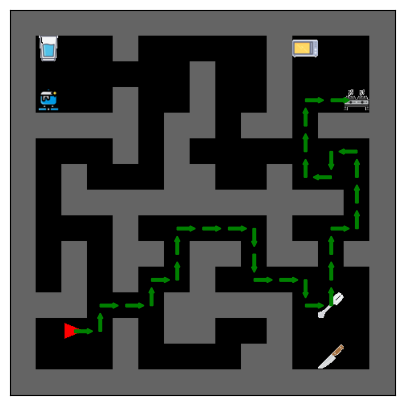

In [56]:
def collect_search_success(env_params, algo, budget=150, seed=0):
    objs = env_params.reset_params.test_objects

    map_init = jax.tree_map(lambda x:x[0], env_params.reset_params.map_init)
    grid = np.asarray(map_init.grid)
    agent_pos = tuple(int(o) for o in map_init.agent_pos)

    path = None
    o = objs[0]
    goal = np.array([o])
    rng = jax.random.PRNGKey(seed)
    while path is None:
        rng, rng_ = jax.random.split(rng)
        print(rng_)
        path, iterations = algo(grid, agent_pos, goal, key=rng_, budget=budget)
    print(iterations)
    return path

def render_search_path(positions, env_params):
    map_init = jax.tree_map(lambda x:x[0], env_params.reset_params.map_init)
    grid = np.asarray(map_init.grid)    
    actions = utils.actions_from_path(positions)
    
    # doesn't matter
    maze_height, maze_width, _ = grid.shape
    
    img = renderer.create_image_from_grid(
        map_init.grid,
        map_init.agent_pos,
        map_init.agent_dir,
        image_dict)
    renderer.place_arrows_on_image(img, positions, actions, maze_height, maze_width)

maze_str = 'maze3_open2'
env_params = get_params(getattr(mazes, maze_str))
budget = 150
path = collect_search_success(env_params=env_params, algo=utils.dfs, budget=budget, seed=5)
render_search_path(path, env_params)

### Signature 3: the agent from a __further__ "on path" location will be faster than __closeer__ "off opath"

/tmp/ipykernel_2270999/3537544777.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, ha='right', fontsize=xlabel_fontsize)
/tmp/ipykernel_2270999/3537544777.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, ha='right', fontsize=xlabel_fontsize)
/tmp/ipykernel_2270999/3537544777.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, ha='right', fontsize=xlabel_fontsize)
/tmp/ipykernel_2270999/3537544777.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, ha='right', fontsize=xlabel_fontsize)
/tmp/ipykernel_2270999/3537544777.py:47: UserWarning: set_ti

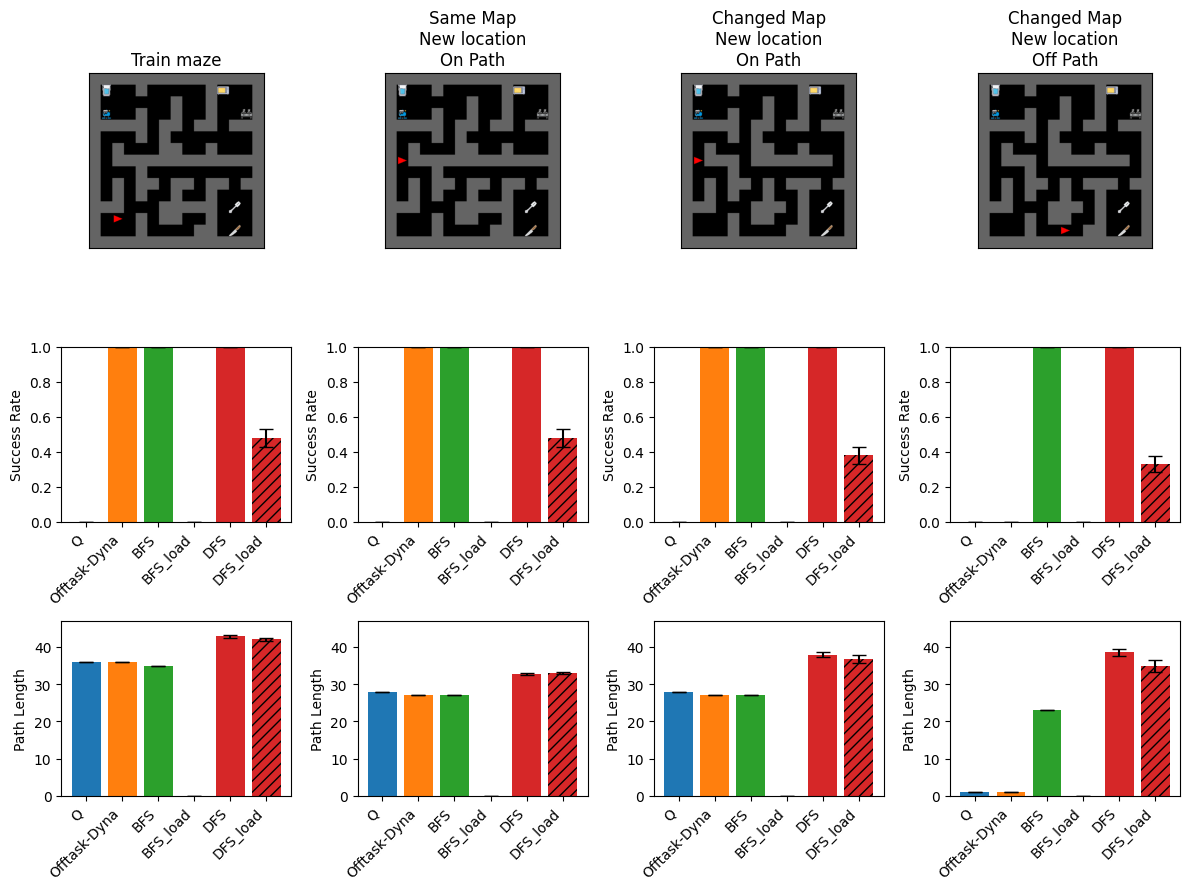

In [58]:
maze_list = ['maze3', 'maze3_onpath', 'maze3_onpath_shortcut', 'maze3_offpath_shortcut']
maze_list = OrderedDict(
    maze3='Train maze',
    maze3_onpath="\n".join(['Same Map', 'New location', 'On Path']),
    maze3_onpath_shortcut="\n".join(['Changed Map', 'New location', 'On Path']),
    maze3_offpath_shortcut="\n".join(['Changed Map', 'New location', 'Off Path']),
)
create_complete_figure(maze_list, show_metrics='both')
# create_complete_figure(maze_list, show_metrics='pl')

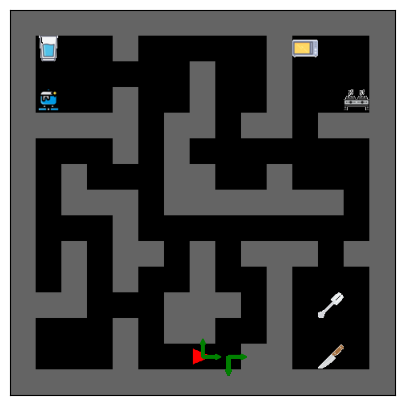

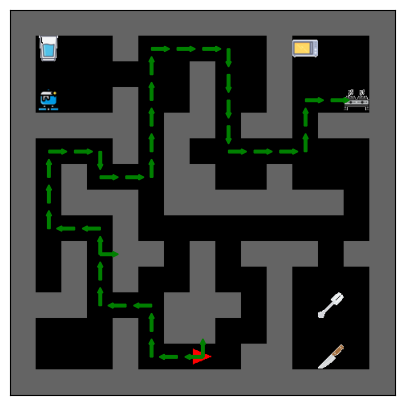

In [60]:
maze_str='maze3_offpath_shortcut'
render_model_path(results[f'dynaq_shared_{maze_str}_train=True'])
render_model_path(results[f'dynaq_shared_{maze_str}_train=False'])

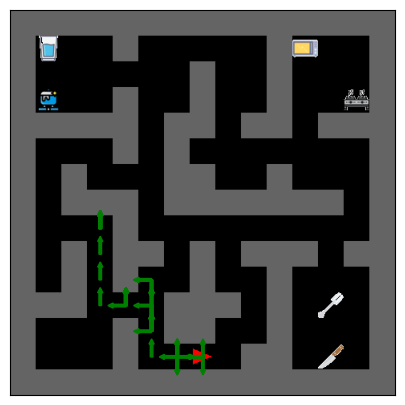

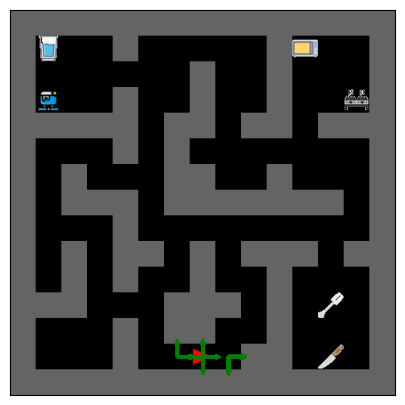

In [61]:
render_model_path(results[f'qlearning_{maze_str}_train=True'])
render_model_path(results[f'qlearning_{maze_str}_train=False'])